# DRL 2019 Assignment 1: Bandits

## Total: 100 points

**Please do not distribute without permission.**

*Special thanks to*: Diana Borsa, Hado van Hasselt, Matteo Hessel



## Content

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 1 and 2

## Objectives

You will use Python to implement several bandit algorithms.

You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [1]:
# Import Useful Libraries

import matplotlib.pyplot as plt
import numpy as np
import collections
from functools import partial

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Returns maximum value."""
    return self._values.max()


In [3]:
class RovingBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=500,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Returns maximum value."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(8, 3*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)

  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], '--k', label='optimal')

      # ax.set_bg_bgcolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

## 1. Basic Agents

This section contains a few agents we implemented for you.  Please read the code and make sure you understand the interface of the agents.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = 'random'

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

In [6]:
class Greedy(object):
  """A greedy agent.

  This agent returns an action between 0 and 'number_of_arms', by always
  selecting the action with the highest estimated value.
  """

  def __init__(self, number_of_arms):
    """Initialise the agent."""
    self._number_of_arms = number_of_arms
    self.name = 'greedy'
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input).  Then, the greedy action
    is returned according to the current (updated) statistics.
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      self._estimates[previous_action] += (r - q_a)/n_a
    action = argmax(self._estimates)
    
    return action

  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    
    This is also used to initialise these statistics on initialisation.
    """
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

In [7]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = '$\epsilon$-greedy with $\epsilon$ = {}'.format(epsilon)
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      self._estimates[previous_action] += (r - q_a)/n_a
    if np.random.random() < self._epsilon:
      action = np.random.randint(self._number_of_arms)
    else:
      action = argmax(self._estimates)
    return action

  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    
    This is also used to initialise these statistics on initialisation.
    """
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

# 1.1 REINFORCE: softmax policies

Derive a REINFORCE policy-gradient method for a multi-armed bandit problem.

The policy is a softmax on action preferences, with temperature T:
$$\pi(a) = \frac{\exp(p(a)/T)}{\sum_b \exp(p(b)/T)}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

### Task 1.1.1 [Question, 10 points]

**Q:** write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$, given the preferences $p_t(\cdot)$, and assuming you selected a specific action $A_t \in \{a_1, \ldots, a_n\}$ and received a reward of $R_t$.


*Answer*
\begin{align*}
p_{t+1}(a)
& \doteq  p_{t}(a)+\alpha (R_{t})(1-\pi (a))
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& \doteq  p_{t}(b) - \alpha(R_{t})\pi_{t}(b)
&& \text{for all $b \ne A_t$}
\end{align*}

*Answer with baseline*
\begin{align*}
p_{t+1}(a)
& \doteq  p_{t}(a)+\alpha (R_{t}-\bar{R_{t}})(1-\pi (a))
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& \doteq  p_{t}(b) - \alpha(R_{t}-\bar{R_{t}})\pi_{t}(b)
&& \text{for all $b \ne A_t$}
\end{align*}

\begin{align*}
\\
\alpha > 0 \text{ is a step-size parameter} \\
\end{align*}

\begin{align*}
\bar{R_{t}} \in \mathbb{R} \text{ is the average of all the rewards up through and including time $t$} \\
\end{align*}

# 1.2 Agent implementations


All agents should be in pure Python.

You cannot use TensorFlow or other AutoDiff packages to compute gradients.

It is fine to use TF-Eager or Numpy for other calculations.

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

The `name` attribute set by the agent's constructor should be unique (e.g., 'greedy', 'ucb', etc.)



### Task 1.2.1 [Coding, 12 pts]

You should **implement** an agent that **explores with UCB**. 

The **whole agent** needs to be contained in the code cell below.  Do **not** use multiple cells.

To start, use a value of 1 for parameter *c*.

In [8]:
class UCB(object):

  def __init__(self, number_of_arms, c=1.0):
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.c = c
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      t   = np.sum(self._counts[previous_action])
      self._estimates[previous_action] += ((r - q_a)/n_a) + self.c*np.sqrt(np.log(t)/n_a)

    action = argmax(self._estimates)
    
    return action

  def reset(self):
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts    = np.zeros((self._number_of_arms,))

class UCB_Explorer(object):

  def __init__(self, number_of_arms, c=1.0, eps=0.1):
    self._number_of_arms = number_of_arms
    self.name = 'ucb-explorer'
    self.c = c
    self.eps = eps
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      t   = np.sum(self._counts)
      self._estimates[previous_action] += ((r - q_a)/n_a) + self.c*np.sqrt(np.log(t)/n_a)
    if np.random.random() < self.eps:
      action = np.random.randint(self._number_of_arms)
    else:
      action = argmax(self._estimates)
    
    return action

  def reset(self):
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts    = np.zeros((self._number_of_arms,))

### Task 1.2.2 [Coding, 14 points]

You should **implement a softmax REINFORCE agent with** and **without a baseline**.

The **whole agent** needs to be contained in the code cell below.  Do **not** use multiple cells.

The constructor should take as arguments:
*  `number_of_arms`, (int), number of discrete actions,
*  `baseline`: (boolean, default False), whether or not to use an average-reward baseline,
*  `step_size`: (float, default 0.1), the step-size for the updates,
*  `temperature`: (float, default 1.0), the temperature of the softmax policy, .


In [9]:
class REINFORCE(object):

  def __init__(
      self, number_of_arms, step_size=0.1, baseline=False, temperature=1.0):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self._baseline = baseline
    self._temperature = temperature
    self.name = 'reinforce, baseline: {}, temperature: {}'.format(
        baseline, temperature)
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
        self._counts[previous_action] += 1.
        t = np.sum(self._counts)
        self.average_reward = self.average_reward + (1./t)*(reward - self.average_reward)
        baseline = self.average_reward if self._baseline else 0. 

        place_holder = self._pref[previous_action] +\
                       self._lr*(reward - baseline)*(1 - self._π[previous_action])
        self._pref = self._pref - self._lr*(reward - baseline)*self._π
        self._pref[previous_action] = place_holder

        exp = np.exp(self._pref)
        self._π = exp / np.sum(exp)

    action = np.random.choice(self._number_of_arms, 1, p=self._π)[0]
    
    return action

  def reset(self):
    self.average_reward = 0
    self._π = np.ones((self._number_of_arms,))/self._number_of_arms
    self._counts = np.zeros((self._number_of_arms,))
    self._pref = np.zeros((self._number_of_arms,))

# 2 Experiments

## 2.1 Stationary Bandits

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


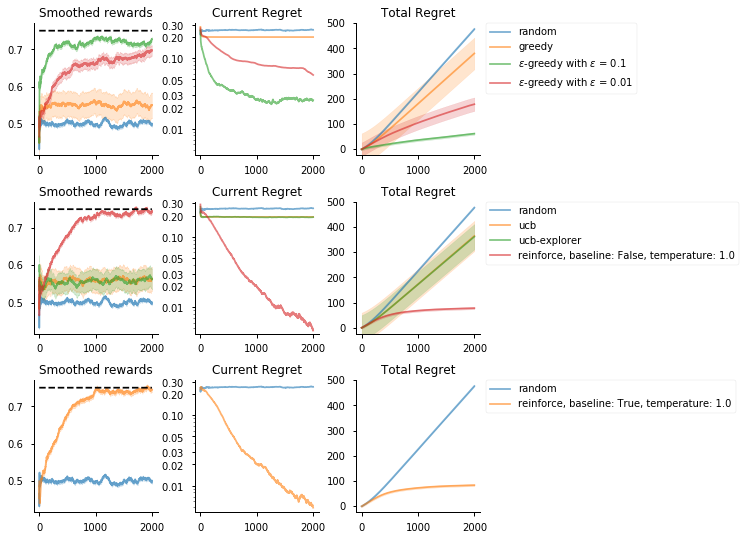

In [10]:
#@title Experiment 1: Bernoulli bandit
#%%capture experiment1

number_of_arms = 5
number_of_steps = 2000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    UCB_Explorer(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

In [30]:
experiment1.show()

NameError: name 'experiment1' is not defined

## 2.1.1 Analyze results

(Answer inline in the markdown below each question, **within this text cell**.)

###Task 2.1.1 [Question, 6 points]

Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

*Answer here.*

###Task 2.1.2 [Question, 4 points]
Which algorithms are guaranteed to have linear total regret?

*Answer here.*

###Task 2.1.3 [Question, 4 points]
 Which algorithms are guaranteed to have logarithmic total regret?

*Answer here.*

###Task 2.1.4 [Question, 6 points]
Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

*Answer here.*

**Run the cell below to train the agents and generate the plots for the second experiment.**

Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

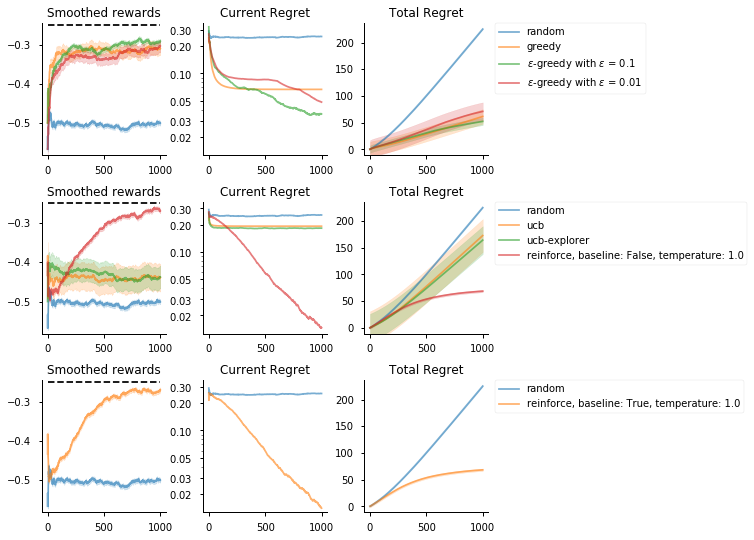

In [62]:
#@title Experiment 2: reward = 0 on success, reward = -1 on failure.
#%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)



In [0]:
experiment2.show()

### Task 2.1.5 [Question, 8 points]

Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

*Answer here*

## 2.2 Non-stationary Bandits

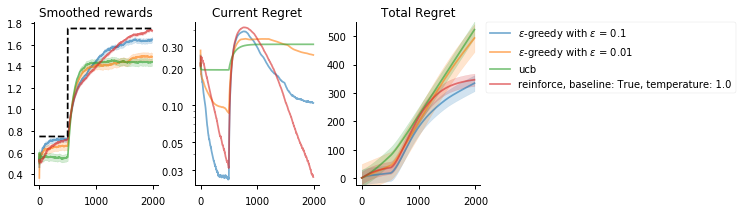

In [63]:
#@title Experiment 3: Non-stationary bandit
# Reward on `failure` changes from 0 to +2.
# Reward on `success` remains at +1.

#%%capture experiment3

number_of_arms = 3
number_of_steps = 1984

agents = [
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms,c=4),
    REINFORCE(number_of_arms, baseline=True),
]

roving_bandit_class = partial(RovingBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

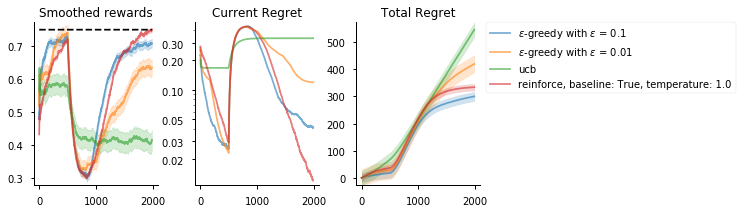

In [64]:
#@title Experiment 4: Non-stationary bandit
# Reward on `failure` changes from 0 to +1.
# Reward on `success` changes from +1 to 0.

#%%capture experiment4

number_of_arms = 3
number_of_steps = 1984

agents = [
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

roving_bandit_class = partial(RovingBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

In [0]:
experiment3.show()

In [0]:
experiment4.show()

## 2.2.1 Analyze Results

Observe the reward and regret curves above.  After 500 steps, the rewards change: `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2, which means that the identity of the optimal action changes.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

### Task 2.2.1 [Question, 8 points] 

Look at the current-regret curve for UCB in **experiment 3**.  Explain why it looks the way it does after the change in rewards.

*Answer here*

### Task 2.2.2 [Question, 6 points] 

Explain why the current-regret curves for $\epsilon$-greedy look different than that of UCB in **experiment 3**.

*Answer here*

### Task 2.2.3 [Question, 6 points] 

Explain why the current-regret curve for REINFORCE looks different than that of UCB in **experiment 3**.

*Answer here*

### Task 2.2.4 [Question, 10 points] 

Compare the current-regret curve for UCB in **experiment 3** to the current regret curve of UCB in **experiment 4**.  Explain why they differ.

*Answer here*

### Task 2.2.5 [Question, 6 points] 

What would happen to the current-regret curve for UCB in **experiment 3** if you used a higher value for parameter *c*? Explain why. (You can try it).

*Answer here*